In [1]:
import os
import rich

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

joint_list = [
    "Nose", "Head", "Left Ear",
    "Right Ear", "Trunk", "Tail Base",
    "Tail_tip", "t0", "t1", "t2",
    "neck", "Left Hpaw", "Right Hpaw",
    "Left Fpaw", "Right Fpaw"
]

In [3]:
data_path = "/mnt/cup/people/tt1131/projects/rotation_project_spring/tracks_evaluation/"
condition_list = ["sham_gdx", "testosterone", "gdx", "intact"]
sample_dict = np.load(
    os.path.join(data_path, f"{condition_list[-1]}_track_dict_abrv.npy"),
    allow_pickle=True,
).item()

In [5]:
# For each item:
# 0: path
# 1. start time 2. track index
# 3. track occupany 4. Joint locations
# 5. Per joint scores 6. Per track scores

for dict_key in sample_dict.keys():
    t_o = sample_dict[dict_key][3]
    js = sample_dict[dict_key][5]
    print(
        f"m1 joint score nan: {sum(np.isnan(js[:, 0, 0]))}, m2 joint score nan: {sum(np.isnan(js[:, 0, 1]))}"
    )
    break

## Proving that only untracked joints have nan values in the joint score array

m1 joint score nan: 33, m2 joint score nan: 99


In [6]:
track_occupancy_list = []
locations_list = []
joint_scores_list = []

for dict_key in sample_dict.keys():
    t_o = sample_dict[dict_key][3]
    loc = sample_dict[dict_key][4]
    js = np.nan_to_num(sample_dict[dict_key][5])

    track_occupancy_list.append(t_o)
    joint_scores_list.append(js)
    locations_list.append(loc)

Mean M1 occupancy: 0.97 +/- 0.09
Mean M2 occupancy: 0.97 +/- 0.05


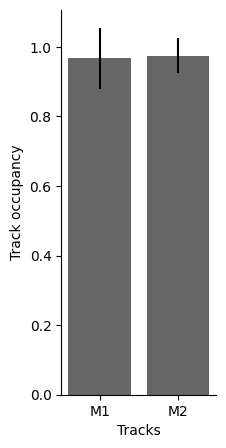

In [7]:
m1_stats = []
m2_stats = []

for i in track_occupancy_list:
    m1_stats.append(np.sum(i[:, 0]) / i.shape[0])
    m2_stats.append(np.sum(i[:, 1]) / i.shape[0])

fig, ax = plt.subplots(figsize=(2, 5))

ax.bar(
    np.arange(1, 3),
    [np.mean(m1_stats), np.mean(m2_stats)],
    yerr=[np.std(m1_stats), np.std(m2_stats)],
    color="black", alpha = .6
)

ax.set_xticks([1, 2])
ax.set_xticklabels(["M1", "M2"])
ax.set_xlabel("Tracks")
ax.set_ylabel("Track occupancy")

sns.despine()

print(f"Mean M1 occupancy: {np.mean(m1_stats):.2f} +/- {np.std(m1_stats):.2f}")
print(f"Mean M2 occupancy: {np.mean(m2_stats):.2f} +/- {np.std(m2_stats):.2f}")

In [8]:
m1_joint_scores = []
m2_joint_scores = []

redo_path = []

all_keys = [*sample_dict.keys()]

for idx, (js, t_o) in enumerate(zip(joint_scores_list, track_occupancy_list)):
    if js.shape[1] == 15:
        m1_joint_score_filt = np.mean(js[t_o[:, 0] == 1, :, 0], axis=0)
        m2_joint_score_filt = np.mean(js[t_o[:, 1] == 1, :, 0], axis=0)

        if sum(m1_joint_score_filt) == 0:
            print(f"Mouse 1, {idx}")
        else:
            m1_joint_scores.append(m1_joint_score_filt)
        if sum(m2_joint_score_filt) == 0:
            print(f"Mouse 2, {idx}")
        else:
            m2_joint_scores.append(m2_joint_score_filt)
    else:
        redo_path.append(sample_dict[all_keys[idx]][0])

m1_joint_scores = np.array(m1_joint_scores)
m2_joint_scores = np.array(m2_joint_scores)

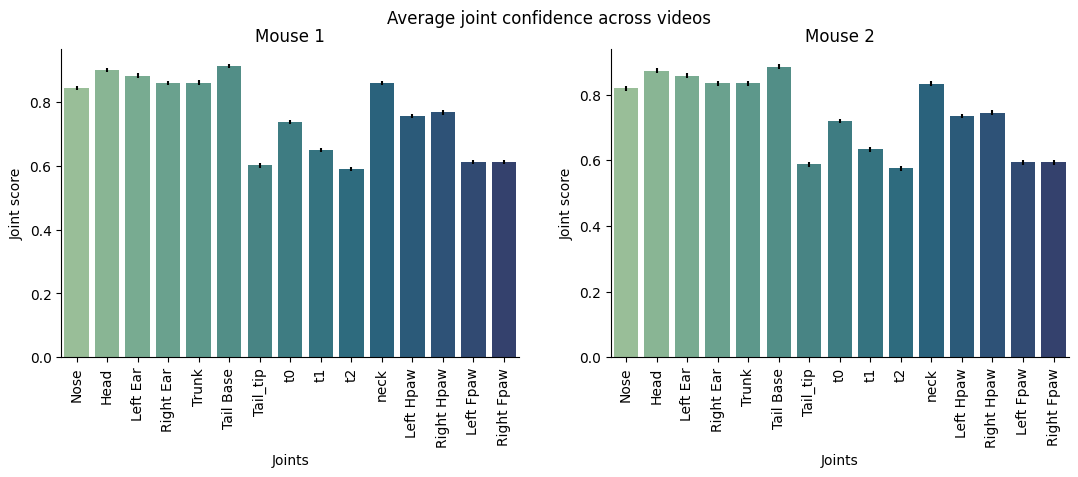

In [9]:
## Average joint confidence across videos

fig, axs = plt.subplots(1, 2, figsize=(13, 4))
joints_arange = np.arange(m1_joint_scores.shape[1])

for idx, js_list in enumerate([m1_joint_scores, m2_joint_scores]):
    sns.barplot(
        x=joints_arange,
        y=np.mean(js_list, axis=0),
        yerr=np.std(js_list) / np.sqrt(js_list.shape[0]),
        palette="crest",
        ax=axs[idx],
    )
    axs[idx].set_xticks(joints_arange)
    axs[idx].set_title(f"Mouse {idx + 1}")
    axs[idx].set_xlabel("Joints")
    axs[idx].set_ylabel("Joint score")
    axs[idx].set_xticklabels(joint_list, rotation=90)

plt.suptitle("Average joint confidence across videos")
sns.despine()

Text(0.5, 0.98, 'Joint scores for 1 random tracks, across 8 joints, labelled with zero track occupancy')

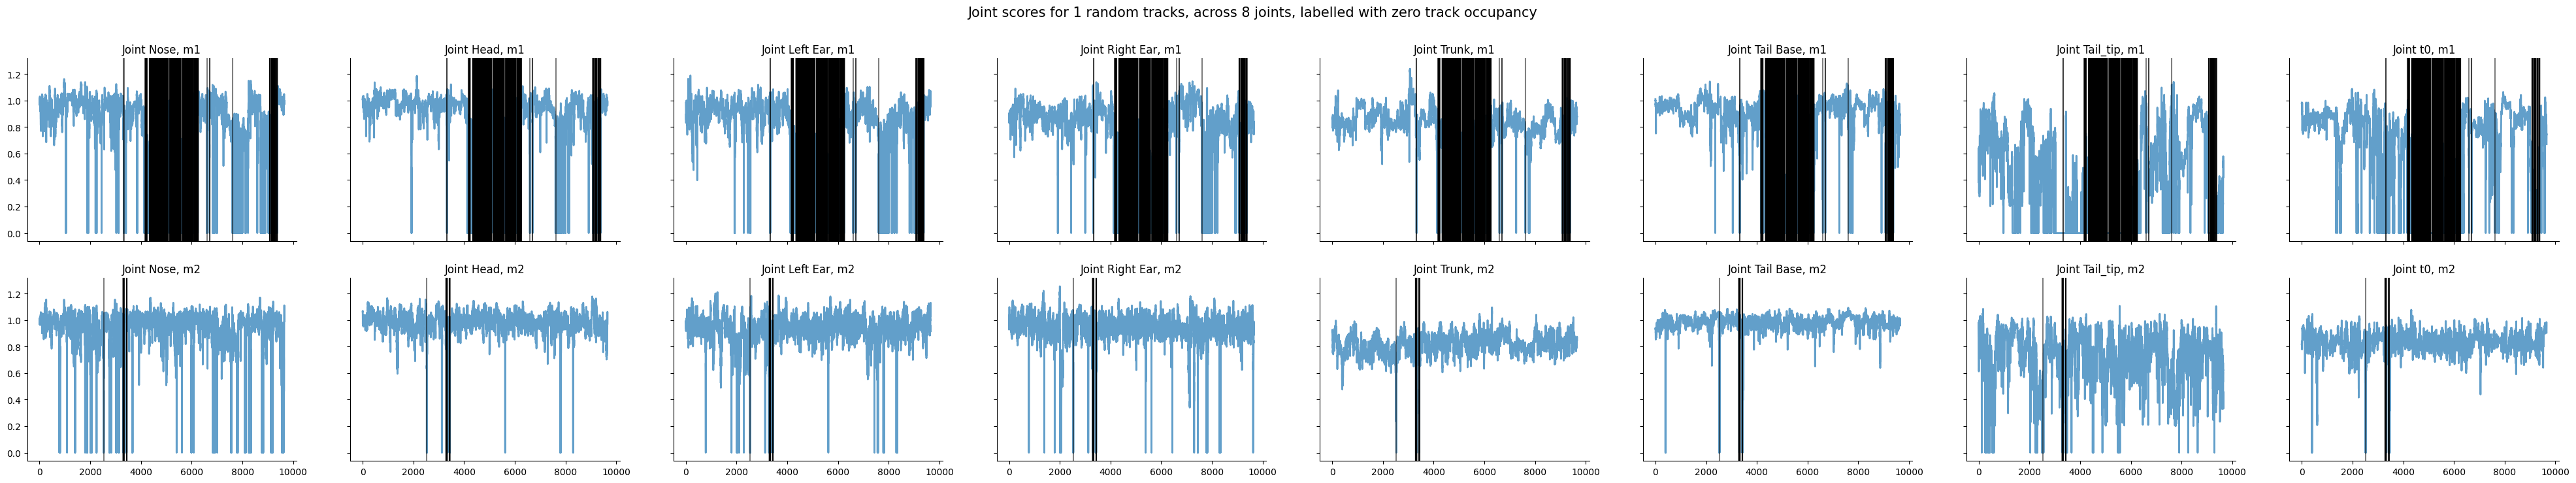

In [29]:
np.random.seed(42)
chosen_idx = 1

random_idx = np.random.choice(np.arange(len(joint_scores_list)), chosen_idx)
m1_joint_score_time = [joint_scores_list[i][:, :, 0] for i in random_idx]
m2_joint_score_time = [joint_scores_list[i][:, :, 1] for i in random_idx]


to_random_list = [track_occupancy_list[i] for i in random_idx]

fig, axs  = plt.subplots(2, 8, figsize = (50, 8), sharex = True, sharey = True)
for m1, m2, to in zip(m1_joint_score_time, m2_joint_score_time, to_random_list):
    m1_nocc = np.where(to[:, 0] == 0)[0]
    m2_nocc = np.where(to[:, 1] == 0)[0]
    for j in range(8):
        axs[0, j].plot(m1[:, j], alpha = .7, lw = 2)
        axs[1, j].plot(m2[:, j], alpha = .7, lw = 2)
        axs[0, j].set_title(f"Joint {joint_list[j]}, m1")
        axs[1, j].set_title(f"Joint {joint_list[j]}, m2")
        
        
        for x1 in m1_nocc:
            axs[0, j].axvline(x1, c = "k", alpha = .5)
            
        for x2 in m2_nocc:
            axs[1, j].axvline(x2, c = "k", alpha = .5)

sns.despine()
plt.suptitle(f"Joint scores for {chosen_idx} random tracks, across 8 joints, labelled with zero track occupancy", fontsize = 15)

Text(0.5, 0.98, 'Joint scores for 1 random tracks, across 8 joints, labelled with zero score')

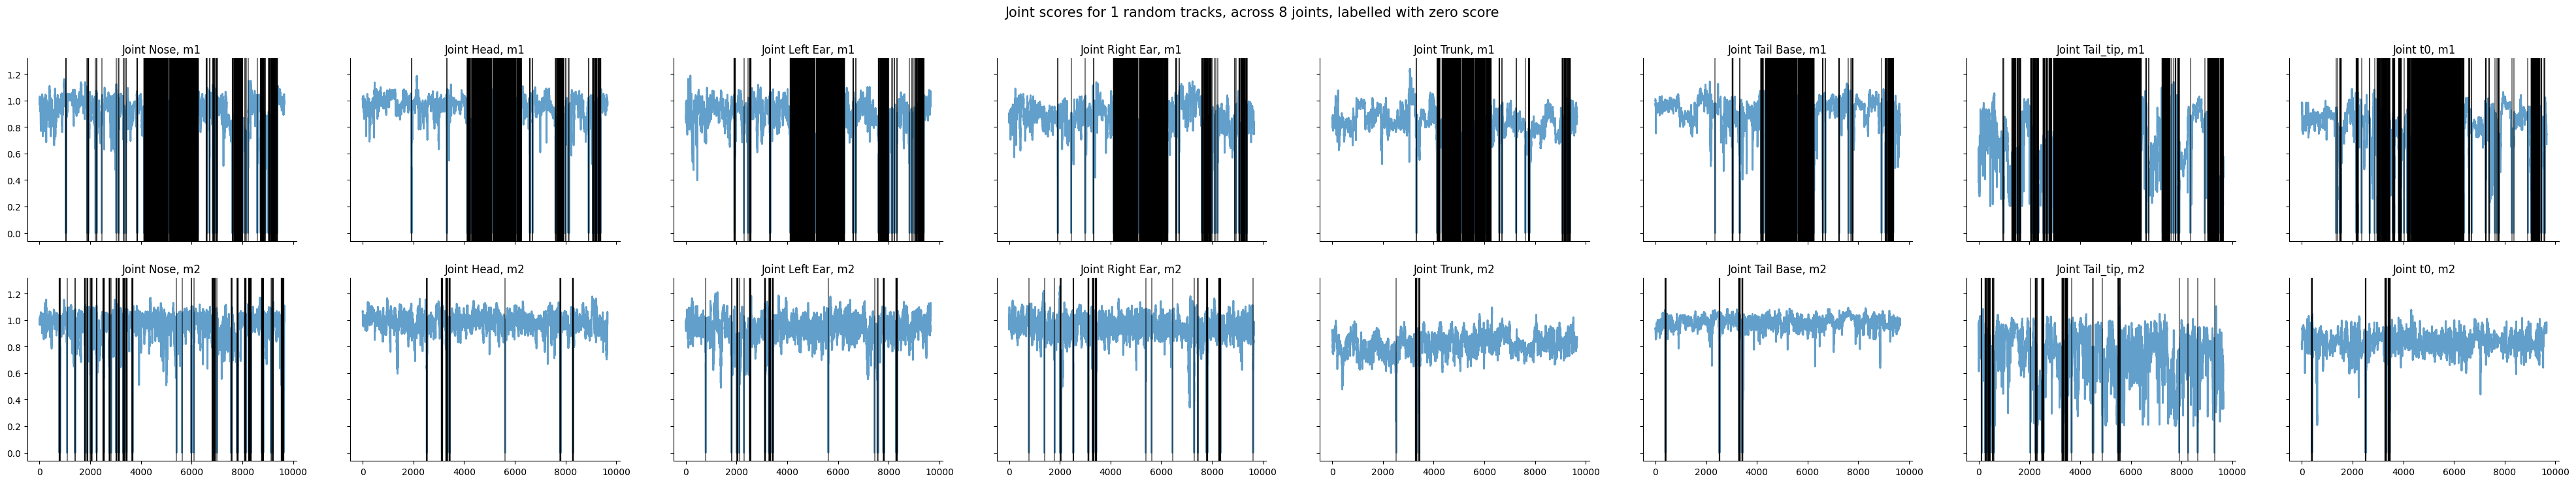

In [30]:
fig, axs  = plt.subplots(2, 8, figsize = (50, 8), sharex = True, sharey = True)
for m1, m2, to in zip(m1_joint_score_time, m2_joint_score_time, to_random_list):

    for j in range(8):
        axs[0, j].plot(m1[:, j], alpha = .7, lw = 2)
        axs[1, j].plot(m2[:, j], alpha = .7, lw = 2)
        axs[0, j].set_title(f"Joint {joint_list[j]}, m1")
        axs[1, j].set_title(f"Joint {joint_list[j]}, m2")

        m1_nocc = np.where(m1[:, j] < 0.1)[0]
        m2_nocc = np.where(m2[:, j] < 0.1)[0]        

        for x1 in m1_nocc:
            axs[0, j].axvline(x1, c = "k", alpha = .5)
            
        for x2 in m2_nocc:
            axs[1, j].axvline(x2, c = "k", alpha = .5)

sns.despine()
plt.suptitle(f"Joint scores for {chosen_idx} random tracks, across 8 joints, labelled with zero score", fontsize = 15)

In [35]:
random_idx = np.random.choice(np.arange(100))
random_to = track_occupancy_list[random_idx]
random_js = joint_scores_list[random_idx]

track_null = np.where(random_to[:, 0] == 0)[0]
joint_null = np.where(random_js[:, 0, 0] < 0.1)[0]

print(f"Proportion of bad examples that are non occupied: {len(track_null) / len(joint_null)}")

Proportion of bad examples that are non occupied: 0.20802005012531327


In [37]:
import copy
from skimage.measure import label

In [60]:
joint_null_count = copy.deepcopy(random_js)[:, :, 0]
for i in range(joint_null_count.shape[1]):
    normal_idx = np.where(joint_null_count[:, i] > .1)[0]
    bad_idx = np.where(joint_null_count[:, i] < .1)[0]
    
    joint_null_count[normal_idx, i] = 0
    joint_null_count[bad_idx, i] = 1

Max frames of missing joint Nose: 46
Max frames of missing joint Head: 45
Max frames of missing joint Left Ear: 48
Max frames of missing joint Right Ear: 47
Max frames of missing joint Trunk: 12
Max frames of missing joint Tail Base: 41
Max frames of missing joint Tail_tip: 148
Max frames of missing joint t0: 81
Max frames of missing joint t1: 66
Max frames of missing joint t2: 143
Max frames of missing joint neck: 45
Max frames of missing joint Left Hpaw: 41
Max frames of missing joint Right Hpaw: 41
Max frames of missing joint Left Fpaw: 46
Max frames of missing joint Right Fpaw: 64


(0.0, 40.0)

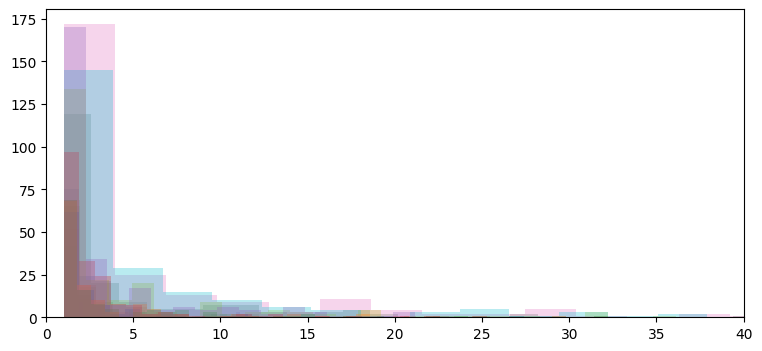

In [79]:
fig, ax = plt.subplots(figsize = (9, 4))

for i in range(joint_null_count.shape[1]):
    connected = label(joint_null_count[:, i])
    ccs = [np.argwhere(connected == i).squeeze() for i in range(connected.max())]
    cc_lengths = np.array([np.size(cc) for cc in ccs])[1:]
    ax.hist(cc_lengths, alpha = .3, bins = 50)
    print(f"Max frames of missing joint {joint_list[i]}: {np.max(cc_lengths)}")
    
ax.set_xlim(0, 40)